In [1]:
from string2string.distance import LevenshteinEditDistance
from rwse import RWSE_Checker
from util.helper import check_token
from transformers import AutoTokenizer

import os
import pandas as pd
import spacy

/Users/dgardner/GitHub/catalpa-cl/rwse-experiments/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rwse = RWSE_Checker(language='de')
nlp = spacy.load('de_core_news_sm')

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.

## Cleaning

In [3]:
collection = dict()
with open('input/dataset_semantic_de.txt', 'r') as f:
    result = []
    idx = 0
    for line in f:
        if line == "\n":
            collection[idx] = result
            idx += 1
            result = []
        else:
            result.append(line.strip())

len(collection)

1407

In [4]:
collection[0]

['7',
 '1761615',
 'jetztigen',
 'jetzigen',
 '650',
 'Wirtschaftssystem oder Politik oder Handlungen Medizin und Erziehungssystem . Dies gelingt nur, wenn die einzelnen Einheiten aneinander anschlussfähig sind, was durch einen systemspezifischen Code geleistet wird, der als zentrale Logik Leitunterscheidung aller Komunikation zugrunde liegt und sie als systemzugehörig erkennbar macht. Im Wirtschaftssystem beispielsweise sorgt der Code Zahlen/nicht Zahlen dafür, dass die Kommunikationen sich auf sich selbst beziehen, und sich selbst reproduzieren kann, also dass auf jede Zahlung eine neue erfolgt. Dies funktioniert über das generalisierte Kommunikationsmedium Geld, das die letzte Zahlung mit der jetztigen verknüpft.Würde das Geld nicht mehr aktzeptiert, folgt der Zahlung keine weitere Zahlung mehr und das System hätte seine Anschlussfähigkeit verloren. Die Anschlussfähigkeit innerhalb eines Systems wird als Selbstreferenz bezeichnet, im Gegensatz zum fremdreferentiellen Bezug auf die U

In [5]:
#file_name = 'input/cleaned_dataset_semantic_de.csv'
file_name = 'input/modified_dataset_semantic_de.csv'

def clean_text(text):
    text = '. '.join([part.strip() for part in text.split('.')]).strip()
    text = '. '.join([part.strip() for part in text.split('?')]).strip()
    return text

def find_sentence(token_text, token_start, text):
    tmp_doc = nlp(clean_text(text))
    for sent in tmp_doc.sents:
        if sent.start_char <= token_start < sent.end_char:
            for tmp_token in sent:
                if tmp_token.text == token_text:
                    tmp_start = tmp_token.idx - sent.start_char
                    tmp_end = tmp_start + len(tmp_token.text)
                    return sent.text[:tmp_start] + '[MASK]' + sent.text[tmp_end:]
    return None

if not os.path.exists(file_name):

    checkpoint = 'bert-base-multilingual-cased'
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    edit_distance = LevenshteinEditDistance()

    cleaned_collection_semantic = []
    bad_words = []
    bad_indices = []
    for key, value in collection.items():
        item = {
            'org_index': int(value[1]),
            'org_token': value[2],
            'org_suggestion': value[3],
            'confusion_set': f'{",".join(sorted([value[2],value[3]]))}',
            'levenshtein': edit_distance.compute(value[2], value[3]),
            'text': find_sentence(value[2], int(value[4]), ' '.join(value[5:]))
        }
        if check_token(tokenizer, item['org_token']) is None:
            bad_words.append(item['org_token'])
        elif check_token(tokenizer, item['org_suggestion']) is None:
            bad_words.append(item['org_suggestion'])
        elif item['text'] is None:
            bad_indices.append(item['org_index'])
        else:
            cleaned_collection_semantic.append(item)


    cleaned_collection_semantic = pd.DataFrame.from_dict(cleaned_collection_semantic)
    for confusion_set in cleaned_collection_semantic['confusion_set'].unique():
        indices = cleaned_collection_semantic[cleaned_collection_semantic['confusion_set'] == confusion_set].index
        if len(indices) == 2:
            cleaned_collection_semantic.drop(min(indices), inplace=True)
    cleaned_collection_semantic.to_csv(file_name, index=False, sep='\t')
    pd.DataFrame(bad_words).to_csv(file_name+'-bad_words', index=False, header=None, sep='\t')
    pd.DataFrame(bad_indices).to_csv(file_name+'-bad_indices', index=False, header=None, sep='\t')
else:
    cleaned_collection_semantic = pd.read_csv(file_name, sep='\t')

cleaned_collection_semantic

,org_index,org_token,org_suggestion,confusion_set,levenshtein,text
0,3929925,Herr,Heer,"Heer,Herr",1.0,"Erst als der Monsun wieder begann, erreichte d..."
1,21426165,After,Alter,"After,Alter",1.0,Im [MASK] von sechs Jahren wurde Turing nach S...
2,26295245,lies,ließ,"lies,ließ",1.0,Auch gegenüber den zahlreichen vegetarischen G...
3,47872734,Wegen,Wagen,"Wagen,Wegen",1.0,Im Römischen Reich wurden um 200 n. Wagen benu...
4,14229212,erhalten,enthalten,"enthalten,erhalten",2.0,Ebenso beliebt sind die kartoffeln Sieglinde a...
5,30929844,erhalten,gehalten,"erhalten,gehalten",2.0,Sie wurden zunächst für einen Zweig des Kuschi...
6,51767464,westlich,wesentlich,"wesentlich,westlich",2.0,Viele HFA-Autisten sind deshalb als Erwachsene...
7,60483276,wird,wirkt,"wird,wirkt",2.0,Biologische Bedeutung Elementares Chlor [MASK]...
8,46454650,Sommer,Somme,"Somme,Sommer",1.0,Frankreich setzte als erste der kriegführenden...
9,8306042,Ecke,Erde,"Ecke,Erde",2.0,"Duergar Die Duergar, auch Dunkelzwerge oder Gr..."


## Analysis

In [6]:
file_name = 'output/report_dataset_semantic_de.csv'

if not os.path.exists(file_name):
    with (open(file_name, 'w') as f):
        print('result', 'index' ,'org_token', 'org_suggestion', 'levenshtein', 'masked_sentence', 'certainty', sep='\t', end='\n', file=f)
        for index, item in cleaned_collection_semantic.iterrows():
            token = item['org_token']
            sentence = item['text']
            rwse.set_confusion_sets([item['confusion_set'].split(',')])
            suggestion, certainty = rwse.check(token, sentence)
            classification_result = 'TP' if suggestion == item['org_suggestion'] else 'FN'

            print(classification_result, item['org_index'], item['org_token'], item['org_suggestion'], item['levenshtein'], sentence, f'{certainty:.8f}', sep='\t', end='\n', file=f)

classification_results = pd.read_csv(file_name, sep='\t')
classification_results

,result,index,org_token,org_suggestion,levenshtein,masked_sentence,certainty
0,TP,3929925,Herr,Heer,1.0,"Erst als der Monsun wieder begann, erreichte d...",0.032606
1,TP,21426165,After,Alter,1.0,Im [MASK] von sechs Jahren wurde Turing nach S...,0.991851
2,TP,26295245,lies,ließ,1.0,Auch gegenüber den zahlreichen vegetarischen G...,0.124205
3,TP,47872734,Wegen,Wagen,1.0,Im Römischen Reich wurden um 200 n. Wagen benu...,0.842296
4,TP,14229212,erhalten,enthalten,2.0,Ebenso beliebt sind die kartoffeln Sieglinde a...,0.443408
5,TP,30929844,erhalten,gehalten,2.0,Sie wurden zunächst für einen Zweig des Kuschi...,0.039792
6,TP,51767464,westlich,wesentlich,2.0,Viele HFA-Autisten sind deshalb als Erwachsene...,0.026764
7,TP,60483276,wird,wirkt,2.0,Biologische Bedeutung Elementares Chlor [MASK]...,0.077922
8,TP,46454650,Sommer,Somme,1.0,Frankreich setzte als erste der kriegführenden...,0.017874
9,TP,8306042,Ecke,Erde,2.0,"Duergar Die Duergar, auch Dunkelzwerge oder Gr...",0.525394


In [7]:
print('sensitivity', len(classification_results[classification_results['result'] == 'TP'])/len(classification_results))

sensitivity 0.9


In [8]:
for value in sorted(classification_results['levenshtein'].unique()):
    current_df = classification_results[classification_results['levenshtein'] == value]
    print('levenshtein', value, 'sensitivity', len(current_df[current_df['result'] == 'TP'])/len(current_df))

levenshtein 1.0 sensitivity 0.9523809523809523
levenshtein 2.0 sensitivity 0.875
levenshtein 3.0 sensitivity 0.0


### True-Positives

In [9]:
classification_results[classification_results['result'] == 'TP']

,result,index,org_token,org_suggestion,levenshtein,masked_sentence,certainty
0,TP,3929925,Herr,Heer,1.0,"Erst als der Monsun wieder begann, erreichte d...",0.032606
1,TP,21426165,After,Alter,1.0,Im [MASK] von sechs Jahren wurde Turing nach S...,0.991851
2,TP,26295245,lies,ließ,1.0,Auch gegenüber den zahlreichen vegetarischen G...,0.124205
3,TP,47872734,Wegen,Wagen,1.0,Im Römischen Reich wurden um 200 n. Wagen benu...,0.842296
4,TP,14229212,erhalten,enthalten,2.0,Ebenso beliebt sind die kartoffeln Sieglinde a...,0.443408
5,TP,30929844,erhalten,gehalten,2.0,Sie wurden zunächst für einen Zweig des Kuschi...,0.039792
6,TP,51767464,westlich,wesentlich,2.0,Viele HFA-Autisten sind deshalb als Erwachsene...,0.026764
7,TP,60483276,wird,wirkt,2.0,Biologische Bedeutung Elementares Chlor [MASK]...,0.077922
8,TP,46454650,Sommer,Somme,1.0,Frankreich setzte als erste der kriegführenden...,0.017874
9,TP,8306042,Ecke,Erde,2.0,"Duergar Die Duergar, auch Dunkelzwerge oder Gr...",0.525394


### False-Negatives

In [10]:
classification_results[classification_results['result'] == 'FN']

,result,index,org_token,org_suggestion,levenshtein,masked_sentence,certainty
12,FN,5072189,Stadium,Stadion,2.0,Dieses [MASK] wird auch für kulturelle Veranst...,0.000527
13,FN,27502267,Glas,Gas,1.0,In der Schmelze wird Kohlensäure frei und löst...,0.017012
14,FN,6183302,Haus,Herz,3.0,Die eigene zur Faust geschlossene Hand stellt ...,0.001257


## Magnitue Search

<Axes: >

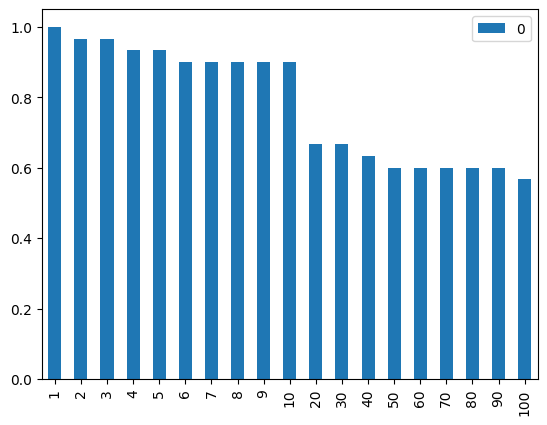

In [11]:
len_dataset = len(cleaned_collection_semantic)
magnitude_search = dict()
ranges = list(range(1, 10)) + list(range(10, 101, 10))
for i in ranges:
    count_TP = 0
    for index, item in cleaned_collection_semantic.iterrows():
        token = item['org_token']
        sentence = item['text']
        rwse.set_confusion_sets([item['confusion_set'].split(',')])
        suggestion, certainty = rwse.check(token, sentence, magnitude=i)
        if suggestion == item['org_suggestion']:
            count_TP += 1
    magnitude_search[i] = count_TP/len_dataset

pd.DataFrame.from_dict(magnitude_search, orient='index').plot(kind='bar')
#pd.DataFrame.from_dict(magnitude_search, orient='index').plot(kind='bar', subplots=True, layout=(1,2), figsize=(10,5))

<Axes: title={'center': 'model sensitivity by magnitude grouped by levenshtein edit distance'}>

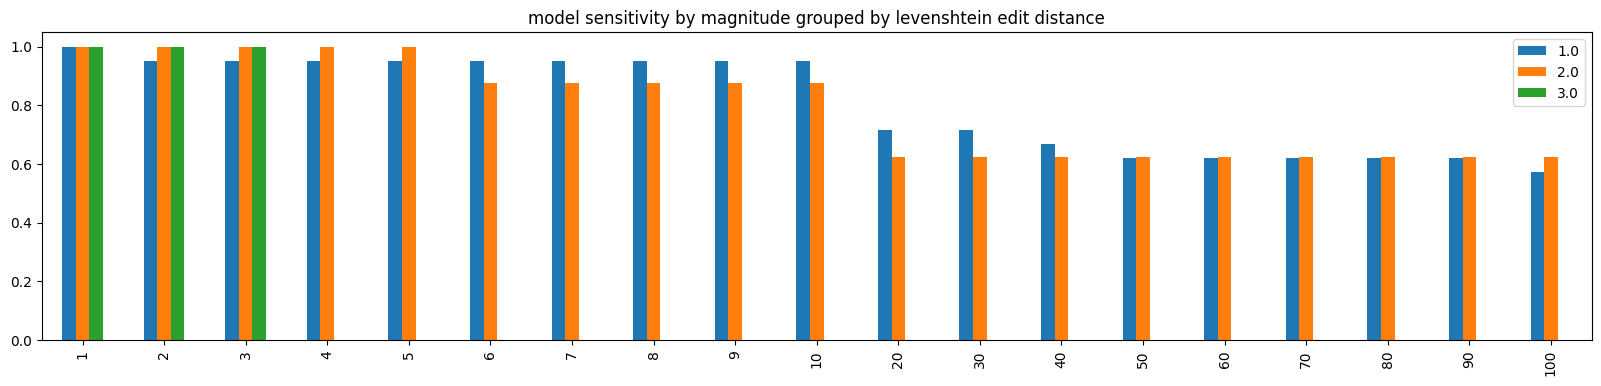

In [12]:
magnitude_search_dict = dict()
ranges = list(range(1, 10)) + list(range(10, 101, 10))
levenshtein_values = sorted(cleaned_collection_semantic['levenshtein'].unique())

for value in levenshtein_values:
    current_df = cleaned_collection_semantic[cleaned_collection_semantic['levenshtein'] == value]
    len_dataset = len(current_df)
    magnitude_search = dict()
    for i in ranges:
        count_TP = 0
        for index, item in current_df.iterrows():
            token = item['org_token']
            sentence = item['text']
            rwse.set_confusion_sets([item['confusion_set'].split(',')])
            suggestion, certainty = rwse.check(token, sentence, magnitude=i)
            if suggestion == item['org_suggestion']:
                count_TP += 1
        magnitude_search[i] = count_TP/len_dataset

    magnitude_search_dict[value] = magnitude_search.values()

tmp_df = pd.DataFrame({
    value: magnitude_search_dict[value] for value in levenshtein_values
}, index=ranges)
tmp_df.plot(kind="bar", figsize=(20,4), title=f'model sensitivity by magnitude grouped by levenshtein edit distance')
